In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/flickr8k/Images.zip" -d Images
!unzip -q "/content/drive/MyDrive/flickr8k/Captions.zip" -d Captions


In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [4]:
image_path = '/content/Images'


In [5]:
import pandas as pd, os

CAPTIONS_FILE = "/content/Captions/captions.txt"   # <- correct in Colab

data = pd.read_csv(CAPTIONS_FILE)

# clean up just in case
data["image"] = data["image"].astype(str).str.strip()
data["caption"] = data["caption"].astype(str).str.strip()

print(data.head(), "\n")
print("Images folder exists?", os.path.isdir(image_path))
print("Samples:", data["image"].head().tolist())
print("First file exists?:", os.path.exists(os.path.join(image_path, data["image"].iloc[0])))


                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...   

Images folder exists? True
Samples: ['1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg']
First file exists?: True


In [6]:
def display_images(temp_df, images_dir="/content/Images", img_size=224, max_n=15):
    import os
    from textwrap import wrap
    import matplotlib.pyplot as plt
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    temp_df = temp_df.reset_index(drop=True)
    n = min(max_n, len(temp_df))
    plt.figure(figsize=(20, 20))
    for i in range(n):
        ax = plt.subplot(5, 5, i+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        img_path = os.path.join(images_dir, temp_df.image[i])

        if os.path.exists(img_path):
            img = load_img(img_path, color_mode="rgb", target_size=(img_size, img_size))
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "Image not found", ha="center", va="center")

        ax.set_title("\n".join(wrap(str(temp_df.caption[i]), 20)))
        ax.axis("off")
    plt.show()


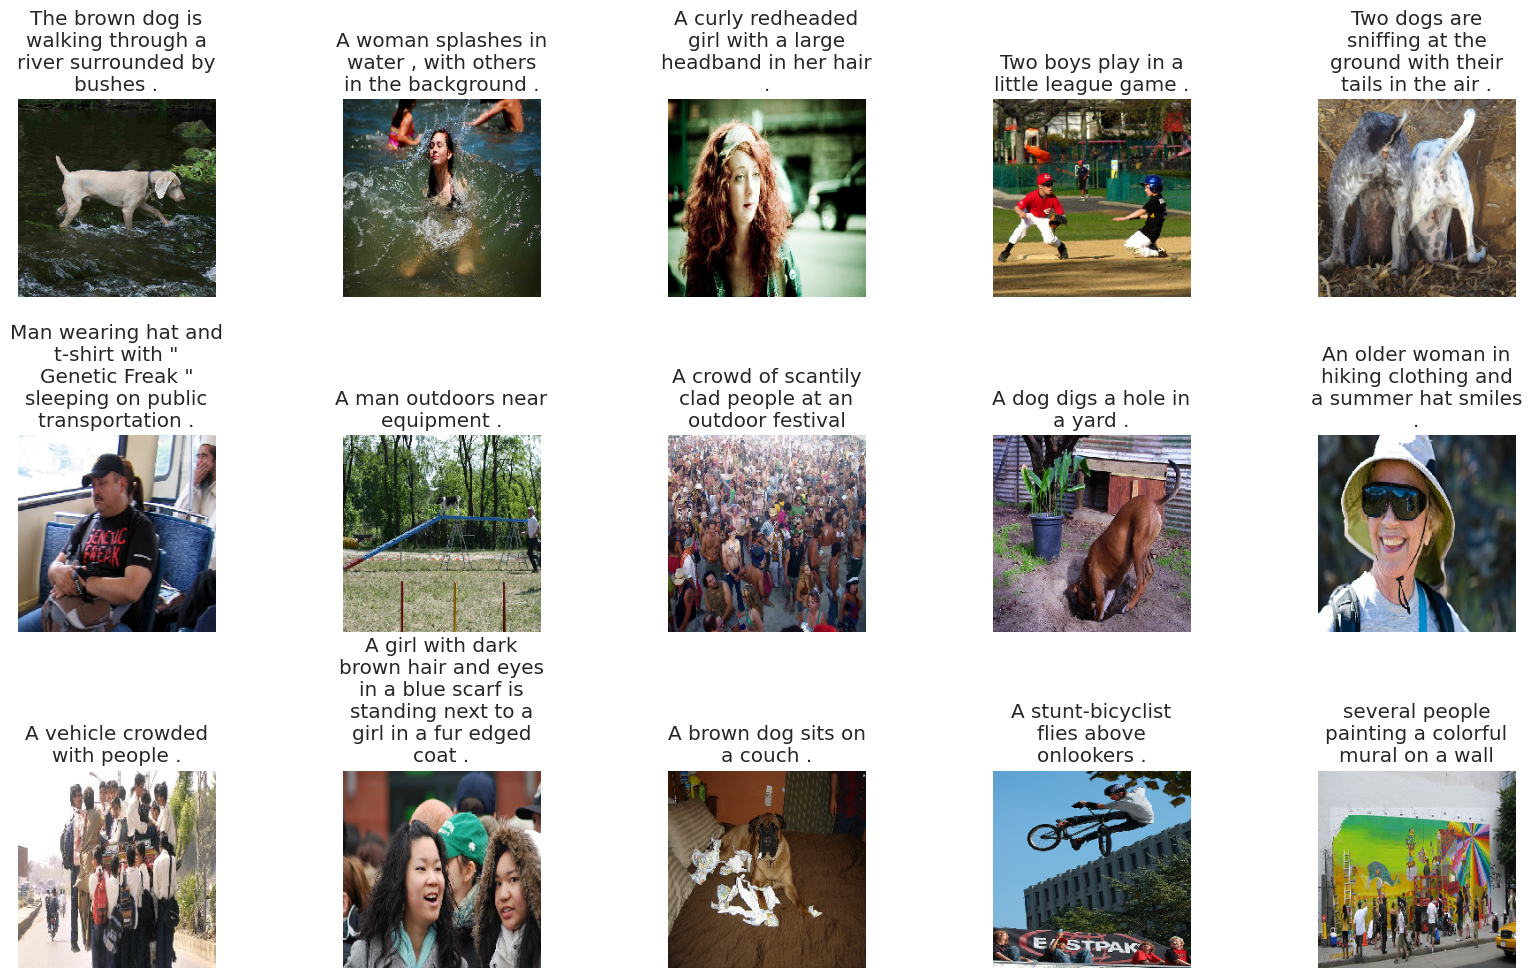

In [7]:
display_images(data.sample(15), images_dir="/content/Images")

In [8]:
import re

def text_preprocessing(data):
    # lowercase
    data['caption'] = data['caption'].str.lower()

    # remove non-alphabet characters
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

    # remove extra spaces
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

    # remove single-character words (a, i kept if needed)
    data['caption'] = data['caption'].apply(lambda x: " ".join([w for w in x.split() if len(w) > 1]))

    # add sequence tokens
    data['caption'] = data['caption'].apply(lambda x: "startseq " + x + " endseq")

    return data


In [9]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 312, 63, 192, 116, 2]

In [11]:
import pickle


# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Tokenizer saved as tokenizer.pkl")

Tokenizer saved as tokenizer.pkl


In [24]:
from tensorflow.keras.applications.densenet import preprocess_input

model = DenseNet201(include_top=False, pooling='avg')
fe = Model(inputs=model.input, outputs=model.output)

img_size = 224
features = {}

for image in tqdm(data['image'].unique().tolist()):
    try:
        img_path = os.path.join(image_path, image)
        img = load_img(img_path, target_size=(img_size, img_size))
        img = img_to_array(img)                     # (224,224,3), float32
        img = np.expand_dims(img, axis=0)           # (1,224,224,3)
        img = preprocess_input(img)                 # DenseNet expected scaling

        vec = fe.predict(img, verbose=0)[0]         # (1920,)
        features[image] = vec.astype('float32')     # store 1D vector
    except Exception as e:
        print("Error:", image, e)


100%|██████████| 8091/8091 [13:44<00:00,  9.81it/s]


In [26]:
with open('image_features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [14]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tqdm import tqdm
import numpy as np
import os

# Load the ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
fe = Model(inputs=model.input, outputs=model.output)

# Set image size
img_size = 224

# Initialize a dictionary to hold features
features = {}

# Correct image path for Colab
image_path = "/content/Images/"

# Extract features for each unique image
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature.flatten()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


100%|██████████| 8091/8091 [11:43<00:00, 11.49it/s]


In [27]:
with open('image_features1.pkl', 'wb') as f:
    pickle.dump(features, f)

In [46]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            # Ensure the entire feature vector is passed
            feature = self.features[image]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [36]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

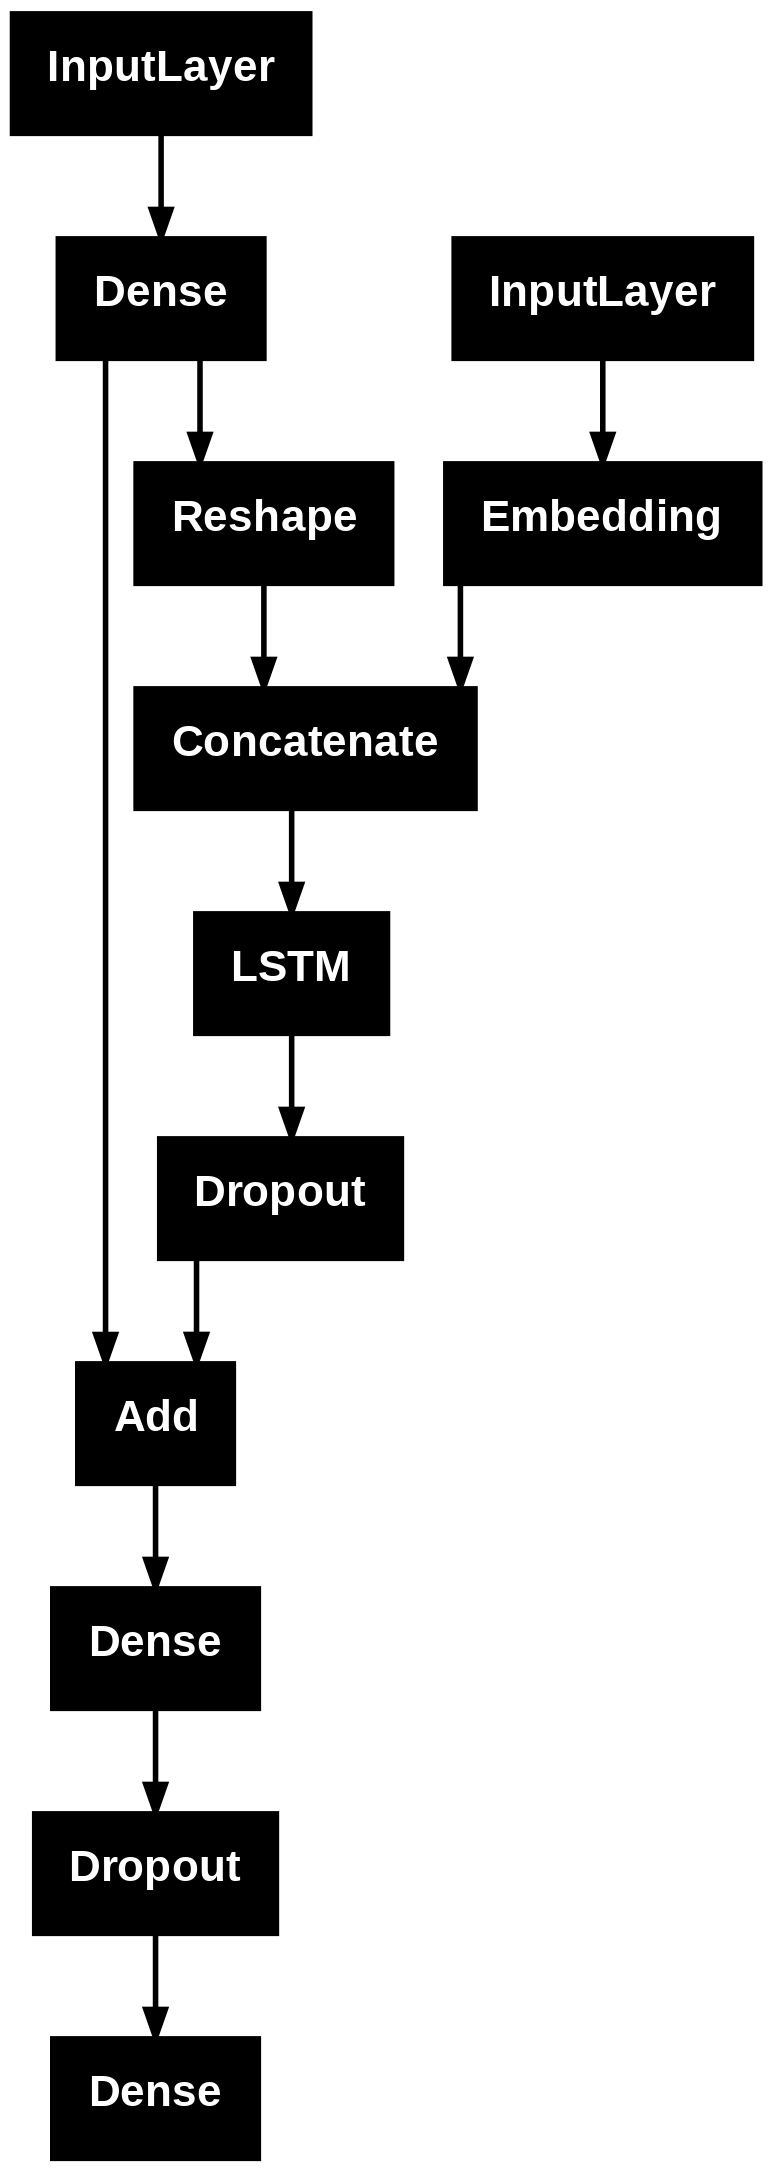

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model)

In [38]:
caption_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    491,776 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 256)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 34, 256)   │  2,244,608 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 35, 256)   │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256)       │          0 │ dropout_4[0][0],  │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8768)      │  1,131,072 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,425,664 (16.88 MB)

 Trainable params: 4,425,664 (16.88 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [40]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [60]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 3.3413
Epoch 1: val_loss did not improve from 3.61533
537/537 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - loss: 3.3413 - val_loss: 3.6195 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 3.2979
Epoch 2: val_loss did not improve from 3.61533
537/537 ━━━━━━━━━━━━━━━━━━━━ 81s 150ms/step - loss: 3.2979 - val_loss: 3.6346 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 3.2511
Epoch 3: val_loss did not improve from 3.61533
537/537 ━━━━━━━━━━━━━━━━━━━━ 80s 149ms/step - loss: 3.2511 - val_loss: 3.6329 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 3.1896
Epoch 4: val_loss did not improve from 3.61533

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
537/537 ━━━━━━━━━━━━━━━━━━━━ 80s 150ms/step - loss: 3.1896 - val_loss: 3.6480 - learning_rate: 0.0010
Epoch 5/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/s

In [61]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [62]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_caption(model, image_name, tokenizer, max_length, features):
    # 1) get precomputed feature vector
    feat = features[image_name]               # (1920,)
    if feat.ndim == 1:
        feat = feat.reshape(1, -1)            # -> (1, 1920)

    # 2) greedy decode
    in_text = "startseq"
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)   # -> (1, max_length)

        yhat = model.predict([feat, seq], verbose=0)    # OK: (1, vocab)
        yhat = np.argmax(yhat, axis=-1)[0]
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    return in_text


In [70]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [71]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

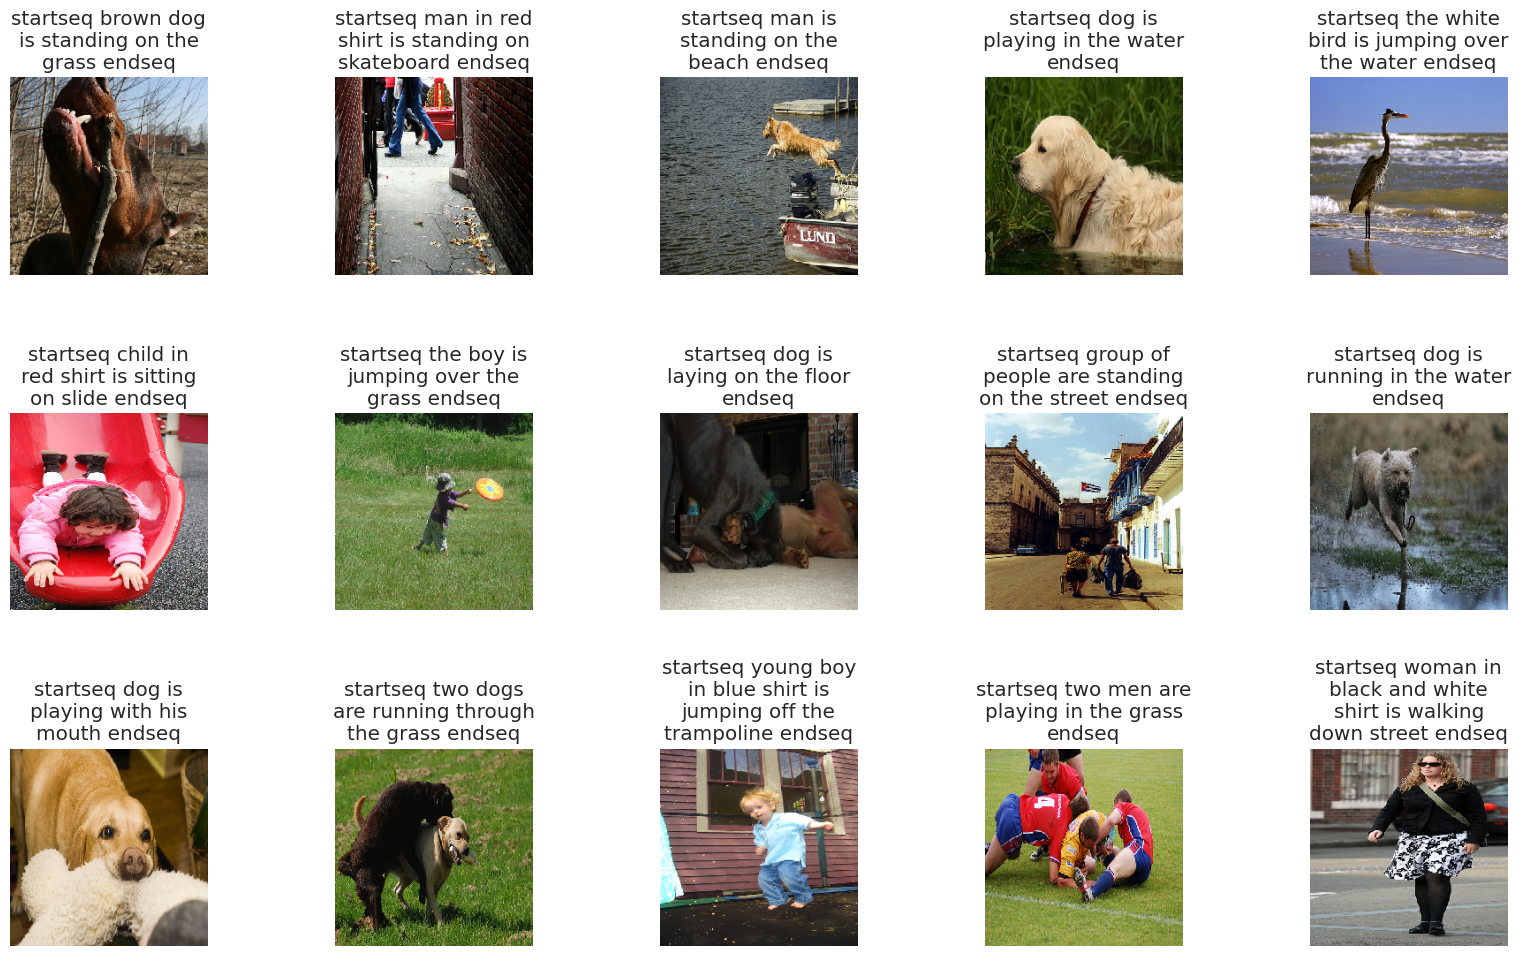

In [72]:
display_images(samples)

In [73]:
from keras.models import load_model

# Load the saved model
caption_model = load_model("model.keras")


In [67]:
!pip install nltk


In [74]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Function to calculate BLEU score for a single caption
def calculate_bleu(reference_caption, predicted_caption):
    reference = [reference_caption.split()]  # Tokenize the reference caption
    candidate = predicted_caption.split()  # Tokenize the predicted caption
    return sentence_bleu(reference, candidate)

# Evaluate BLEU score on a sample set of test data
bleu_scores = []
for index, record in samples.iterrows():
    # Load image and generate a predicted caption
    predicted_caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)

    # Ground truth caption (remove startseq and endseq for comparison)
    reference_caption = record['caption'].replace("startseq", "").replace("endseq", "").strip()

    # Calculate BLEU score for this sample
    bleu_score = calculate_bleu(reference_caption, predicted_caption)
    bleu_scores.append(bleu_score)

# Average BLEU score across the sample set
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {avg_bleu_score}")


Average BLEU Score: 0.730616465375965
